# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Нужно исследовать данные и сделать выводы по полученным результатам. Вдобавок, к рассуждениям и выводам добавим визуализацию и с помощью статистического тестирования проверим, являются ли выводы статистически значимыми.

Задачи:
1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
* Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Значения столбцов датасета:

* work_year	- Год, в котором была выплачена зарплата.
* experience_level	 - Опыт работы на этой должности в течение года со следующими возможными значениями:
    * EN — Entry-level/Junior;
    * MI — Mid-level/Intermediate;
    * SE — Senior-level/Expert;
    * EX — Executive-level/Director.
* employment_type	- Тип трудоустройства для этой роли:
    * PT — неполный рабочий день;
    * FT — полный рабочий день;
    * CT — контракт;
    * FL — фриланс.
* job_title	Роль, в которой соискатель работал в течение года.
* salary	Общая выплаченная валовая сумма заработной платы.
* salary_currency	Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* salary_in_usd	Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* employee_residence	Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* remote_ratio	Общий объём работы, выполняемой удалённо. Возможные значения:
    * 0 — удалённой работы нет (менее 20 %);
    * 50 — частично удалённая работа;
    * 100 — полностью удалённая работа (более 80 %).
* company_location	Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size	Среднее количество людей, работавших в компании в течение года:
    * S — менее 50 сотрудников (небольшая компания);
    * M — от 50 до 250 сотрудников (средняя компания);
    * L — более 250 сотрудников (крупная компания).

Источник: https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries

# Загрузка и обработка данных. Отбор признаков

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import category_encoders as ce
from statsmodels.stats.contingency_tables import mcnemar

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Задаём уровень значимости
alpha = 0.05

In [3]:
# Считываем данные
data = pd.read_csv('data\ds_salaries.csv', index_col=0)
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [4]:
# Проверим, сколько дубликатов содержится в таблице
dup_lst = data.duplicated()
dup_lst.sum()

42

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


*Как видим, в данном датафрейме нет дубликатов, все типы данных - корректные* 

---

Теперь отберём признаки. Сразу понятно, что зарплату лучше сравнивать только в долларах, т.е. оставить только признак salary_in_usd.

In [6]:
# Удаляем ненужные признаки
data = data.drop(['salary', 'salary_currency'], axis=1)
data.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


Также подозрение вызывает признаки 'employee_residence' и 'company_location', которые, скорее всего имеют высокую корреляцию. Проверим это:

In [7]:
count = 0
# Проходимся циклом for по строкам таблицы 
for i in data.index:
    # Если значения признаков 'employee_residence' и 'company_location' равны, добавляем к счетчику единицу
    if data.loc[i]['company_location'] == data.loc[i]['employee_residence']:
        count += 1
        
# Выводим долю повторяющихся значений
round(count/len(data), 2)

0.92

Как видим, более 90% информации в этих двух признаках совпадает. Оставляем признак 'company_location', т.к. он более информативен (если можно так сказать, зарплату выплачивает компания, а не страна, в которой работает программист)

In [8]:
# Удаляем ненужные признаки
data = data.drop('employee_residence', axis=1)

---

Итак, наконец, получили датафрейм, с которым будем работать:

In [9]:
data

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,50,US,L
...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,100,US,M
603,2022,SE,FT,Data Engineer,126000,100,US,M
604,2022,SE,FT,Data Analyst,129000,0,US,M
605,2022,SE,FT,Data Analyst,150000,100,US,M


Разделим данные на типы:
* Категориальные: work_year, experience_level, employment_type, job_title, remote_ratio, company_location, company_size
* Количественные: salary_in_usd

# Визуализация 

Text(0, 0.5, 'Распределение')

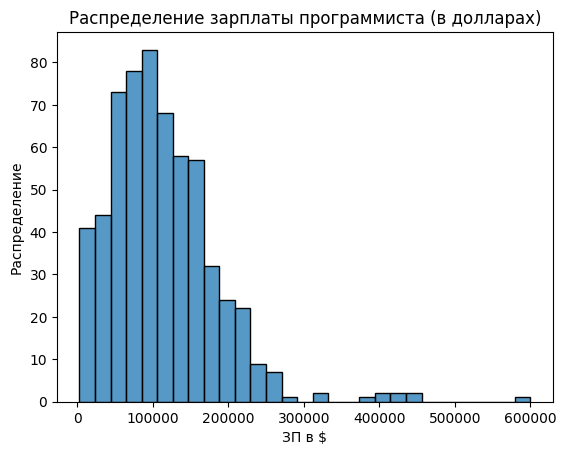

In [10]:
# С помощью библиотеки Seaborn строим гистограмму распределения зарплаты
ax = sns.histplot(data['salary_in_usd'])

ax.set_title('Распределение зарплаты программиста (в долларах)')
ax.set_xlabel('ЗП в $')
ax.set_ylabel('Распределение')

Как видим, общая ЗП распределена ненормально. Конечно, мы будем проводить тесты по каждой выборке, но скорее всего везде придется использовать непараметрические тесты.

---

In [11]:
d = data.groupby('work_year')['work_year'].count()
d

work_year
2020     72
2021    217
2022    318
Name: work_year, dtype: int64

Text(0, 0.5, 'Кол-во')

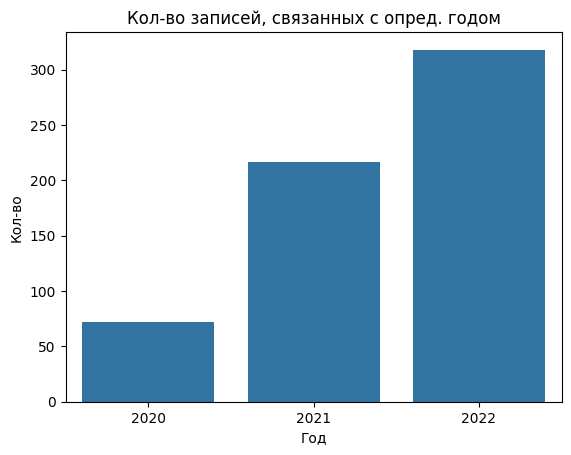

In [12]:
# С помощью библиотеки Seaborn добавляем
ax = sns.barplot(data=d)
# Добавляем название осям и всей диаграмме
ax.set_title('Кол-во записей, связанных с опред. годом')
ax.set_xlabel('Год')
ax.set_ylabel('Кол-во')

Как видно, больше всего данных предоставлено за 2022 год.

---

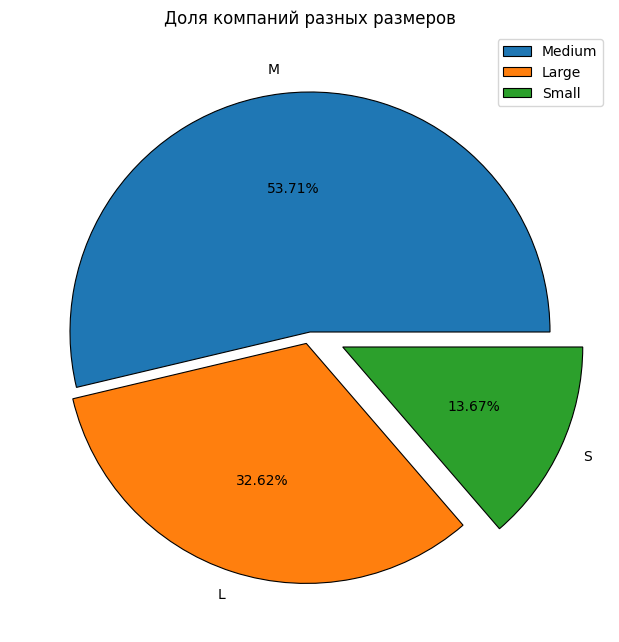

In [13]:
df = data['company_size'].value_counts()
# С помощью библиотеки matplotlib строим круговую диаграмму
ax = plt.figure(figsize=(8, 6)).add_axes([0, 0, 1, 1])
ax.pie(
    df, 
    labels = df.index,
    autopct = '%.2f%%',
    explode = (0, 0.05, 0.15),
    wedgeprops = {'lw':0.8,'edgecolor':'k'}
)
# Добавляем название графику и легенду
ax.set_title('Доля компаний разных размеров')
ax.legend(['Medium', 'Large', 'Small'])

Видим, что больше всего компаний (53%) в данном датафрейме - среднего размера, треть - большого, остальные - маленькие.

---

Text(0, 0.5, 'Кол-во')

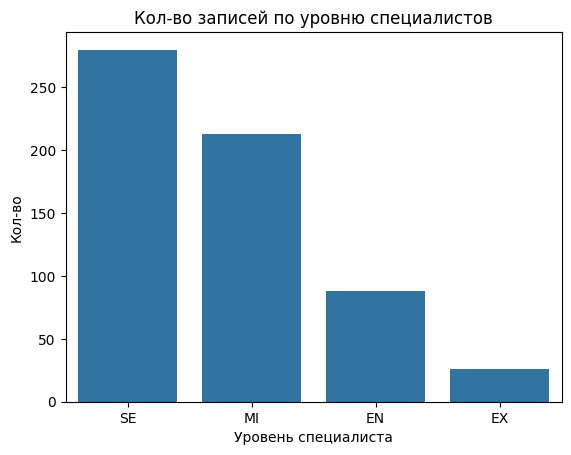

In [14]:
# С помощью Seaborn строим столбчатую диаграмму для уровней специалистов
ax = sns.barplot(data['experience_level'].value_counts())
# Добавляем подписи осей и всего графика
ax.set_title('Кол-во записей по уровню специалистов')
ax.set_xlabel('Уровень специалиста')
ax.set_ylabel('Кол-во')

Из данного графика можем сделать вывод, что большинство работников из данного датафрейма имеют глубокие знания в своей сфере (преобладает группа 'Senior')

---

Text(0.5, 1.0, 'Доля работающих удалённо/в офисе')

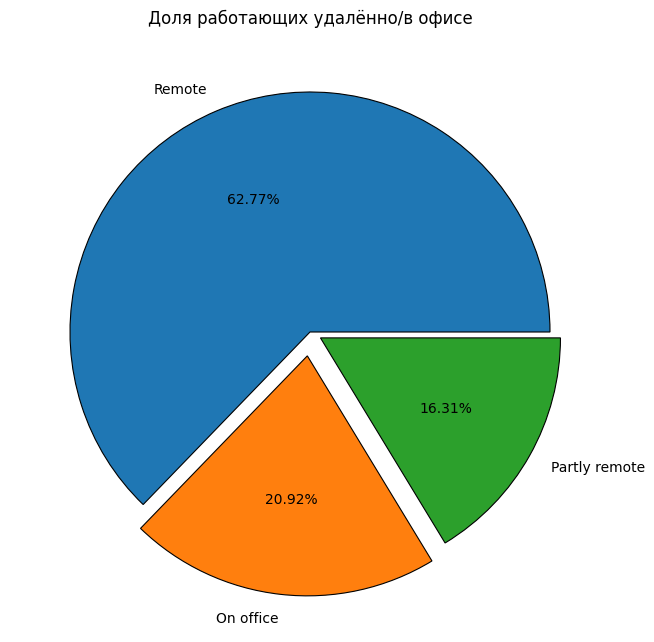

In [15]:
df = data['remote_ratio'].value_counts()
df.index = ['Remote', 'On office', 'Partly remote']
# С помощью библиотеки matplotlib строим круговую диаграмму
ax = plt.figure(figsize=(8, 6)).add_axes([0, 0, 1, 1])
ax.pie(
    df, 
    labels = df.index,
    autopct = '%.2f%%',
    explode = (0, 0.1, 0.05),
    wedgeprops = {'lw':0.8,'edgecolor':'k'}
    
)
# Добавляем название графику
ax.set_title('Доля работающих удалённо/в офисе')

Как видно по диаграмме, большинство работников (62 %) из исходного датафрейма работают удалённо, пятая часть из всех - в офисе (очно), оставшиеся 16% работают спешанно (очно + заочно)

# №1. Исследование ежегодного роста зарплаты

In [16]:
data['work_year'].value_counts()

work_year
2022    318
2021    217
2020     72
Name: count, dtype: int64

Как видим, в исходных данных упоминается всего три года: 2020, 2021 и 2022. 

*Можем обозначить общую нулевую гипотезу: хотя бы где-то в последовательности годов зарплата меньше либо равна предыдущему. Алтернативная гипотеза: с каждым годом зарплата дата сайентиста увеличивается.*

In [17]:
# Отдельно выделим датафрейм df, в котором упоминаются только дата сайентисты
df = data[data['job_title'] == 'Data Scientist']

# Создадим маски, с помощью которых из датафрейма df выделим статистику за 2022,
# 2021 и 2020 год соответственно
mask_1 = data['work_year'] == 2022
mask_2 = data['work_year'] == 2021
mask_3 = data['work_year'] == 2020

# Сохраним переменные с датафреймами с одним годом
df_1 = df[mask_1]
df_2 = df[mask_2]
df_3 = df[mask_3]

---

*Нулевая гипотеза* ($H_0$): средняя зарплата Data Scientist в 2022 году ($μ_1$) статистически меньше либо равна размеру заработной платы в 2021 ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): средняя зарплата Data Scientist в 2022 году ($μ_1$) статистически больше, чем ЗП Дата-сайентиста в 2021 ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

Перед тем, как выбрать статистический тест, проверим распределение обоих признаков:

In [18]:
# Используем метод shapiro() из библиотеки scipy для проверки данных на нормальность:
_, p_1 = stats.shapiro(df_1['salary_in_usd'])
_, p_2 = stats.shapiro(df_2['salary_in_usd'])
# Нулевая гипотеза: данные распределены нормально, альтернативная - нет
if p_1 >= alpha and p_2 >= alpha:
    print('p-значение обоих больше, чем заданный уровень значимости {:.2f}. \nСледовательно, оба списка распределены нормально. Используем параметрический тест'.format(alpha))
else:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. \nЗначит, какой-то из признаков распределён ненормально. Используем непараметрический тест'.format(alpha))

p-значение обоих больше, чем заданный уровень значимости 0.05. 
Следовательно, оба списка распределены нормально. Используем параметрический тест


Итак, мы имеем два количественных, независимых, нормально распределённых признака.

Используем двухвыборочный t-критерий:

In [19]:
# Используем функцию ttest_ind из библиотеки scipy
_, p = stats.ttest_ind(df_1['salary_in_usd'], df_2['salary_in_usd'], alternative='greater')
# Выбираем верную гипотезу
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Таким образом, справедлива альтернативная гипотеза: ЗП Data Scientist в 2022 году больше, чем в 2021.

---

Теперь сравним зарплату дата сайентиста в 2021 и 2020 году:

*Нулевая гипотеза* ($H_0$): средняя зарплата Data Scientist в 2021 году ($μ_1$) статистически меньше либо равна размеру заработной платы в 2020 ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): средняя зарплата Data Scientist в 2021 году ($μ_1$) статистически больше, чем ЗП Дата-сайентиста в 2020 ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

Перед тем, как выбрать статистический тест, проверим распределение обоих признаков:

In [20]:
# Используем метод shapiro() из библиотеки scipy для проверки данных на нормальность:
_, p_1 = stats.shapiro(df_2['salary_in_usd'])
_, p_2 = stats.shapiro(df_3['salary_in_usd'])
# Нулевая гипотеза: данные распределены нормально, альтернативная - нет
if p_1 >= alpha and p_2 >= alpha:
    print('p-значение обоих больше, чем заданный уровень значимости {:.2f}. \nСледовательно, оба списка распределены нормально. Используем параметрический тест'.format(alpha))
else:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. \nЗначит, какой-то из признаков распределён ненормально. Используем непараметрический тест'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05. 
Значит, какой-то из признаков распределён ненормально. Используем непараметрический тест


Итак, мы имеем два количественных, независимых, ненормально распределённых признака.

Используем U-критерий Манна-Уитни:

In [21]:
_, p = stats.mannwhitneyu(df_2['salary_in_usd'], df_3['salary_in_usd'], alternative='greater')

if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


То есть, у нас нет оснований утверждать, что ЗП Data Scientist в 2021 году стала больше, чем в 2020.

---

<span style="font-size:24px;">**Вывод:**</span> $~$ <span style="font-size:20px;">ежегодный прирост зарплаты наблюдается только в 2022 году, т.е. у нас нет оснований утверждать, что ЗП дата сайентиста постоянно увеличивается.</span>

# №2. Исследование соотношения зарплат Data Scientist и Data Engineer в 2022 году

In [22]:
# Сохраним датафрейм, содержащий информацию о дата сайентистах и дата инженерах за 2022 год
ds = data[(data['job_title'] == 'Data Scientist') & (data['work_year'] == 2022)]
de = data[(data['job_title'] == 'Data Engineer') & (data['work_year'] == 2022)]

In [23]:
# Используем метод shapiro() из библиотеки scipy для проверки данных на нормальность:
_, p_1 = stats.shapiro(de['salary_in_usd'])
_, p_2 = stats.shapiro(ds['salary_in_usd'])
# Нулевая гипотеза: данные распределены нормально, альтернативная - нет
if p_1 >= alpha and p_2 >= alpha:
    print('p-значение обоих больше, чем заданный уровень значимости {:.2f}. \nСледовательно, оба списка распределены нормально. Используем параметрический тест'.format(alpha))
else:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. \nЗначит, какой-то из признаков распределён ненормально. Используем непараметрический тест'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05. 
Значит, какой-то из признаков распределён ненормально. Используем непараметрический тест


*Нулевая гипотеза* ($H_0$): средняя зарплата Data Scientist в 2022 году ($μ_1$) статистически меньше либо равна размеру заработной платы Data Engineer в том же году ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): средняя зарплата Data Scientist в 2022 году ($μ_1$) статистически больше, чем ЗП Data Engineer в 2022 ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

Итак, мы исследуем две независимые группы, в каждой из которых количественный признак (ЗП) и данные распределены ненормально => используем U-критерий Манна-Уитни.

In [24]:
_, p = stats.mannwhitneyu(ds['salary_in_usd'], de['salary_in_usd'], alternative='greater', )
print(p)

0.0773245890781616


In [25]:
print(f'Mean salary in 2022: Data Engineer - {round(de['salary_in_usd'].mean())}, Data Scientist - {round(ds['salary_in_usd'].mean())} \nMedian salary in 2022: Data Engineer - {de['salary_in_usd'].median()}, Data Scientist - {ds['salary_in_usd'].median()}')

Mean salary in 2022: Data Engineer - 126376, Data Scientist - 136172 
Median salary in 2022: Data Engineer - 120000.0, Data Scientist - 140000.0


Как видим, тест Манна-Уитни вывел значение p-value чуть больше установленного уровня значимости (alpha), следовательно, мы должны отвергнуть альтернативную гипотезу, что зарплата дата сайентиста больше зарплаты дата инженера. Но на самом деле, как видно из запроса сверху, ЗП Data Scientist на 10-20 тысяч больше, чем у Data Engineer, что можно считать существенным. В данном случае можем сказать, что мы принимаем aplha за 0,1 и поэтому выбираем альтернативную гипотезу.

---

<span style="font-size:24px;">**Вывод:**</span> $~$ <span style="font-size:20px;">исходя из статистического теста Манна-Уитни, в 2022 году ЗП Data Scientist была больше, чем у Data Engineer.</span>

# №3. Соотношение зарплат Data Scientist взависимости от размера компании

In [26]:
data['company_size'].value_counts()

company_size
M    326
L    198
S     83
Name: count, dtype: int64

где S - маленькая компания, M - средняя, L - большая.

In [27]:
dm = data[data['company_size'] == 'M']
ds = data[data['company_size'] == 'S']
dl = data[data['company_size'] == 'L']

Итак, имеем 3 независимых группы. Проверим распределение в каждой из них:

In [28]:
# Используем метод shapiro() из библиотеки scipy для проверки данных на нормальность:
_, p_1 = stats.shapiro(ds['salary_in_usd'])
_, p_2 = stats.shapiro(dm['salary_in_usd'])
_, p_3 = stats.shapiro(dl['salary_in_usd'])
# Нулевая гипотеза: данные распределены нормально, альтернативная - нет
if p_1 >= alpha and p_2 >= alpha and p_3 >= alpha:
    print('p-значение обоих больше, чем заданный уровень значимости {:.2f}. \nСледовательно, оба списка распределены нормально. Используем параметрический тест'.format(alpha))
else:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. \nЗначит, какой-то из признаков распределён ненормально. Используем непараметрический тест'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05. 
Значит, какой-то из признаков распределён ненормально. Используем непараметрический тест


*Нулевая гипотеза* ($H_0$): средняя зарплата Data Scientist не зависит от размера компании (т.е. медианная зарплаты дата сайентиста в маленькой ($μ_1$), средней ($μ_2$) и большой ($μ_3$) компании равны):

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): средняя зарплата Data Scientist зависит от размера компании (т.е. медианная зарплаты дата сайентиста в маленькой ($μ_1$), средней ($μ_2$) и большой ($μ_3$) компании не равны):

$$ H_1 : μ_1 ≠ μ_2 ≠ μ_3$$

Таким образом, нам подходит тест Краскела-Уоллиса:

In [29]:
# Используем функцию kruskal() библиотеки scipy
_, p = stats.kruskal(ds['salary_in_usd'], dm['salary_in_usd'], dl['salary_in_usd'])
# Выбираем гипотезу
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Итак, как и ожидалось, размеры ЗП Data Scientist зависит от размера компании.

<span style="font-size:24px;">**Вывод:**</span> $~$ <span style="font-size:20px;">исходя из статистического теста Краскела-Уоллиса, ЗП Data Scientist зависит от размера компании.</span>

# №4. Связь между размерами компаний и профессиями Data Scientist и Data Engineer

В данном случае рассматриваем зависимость категориальных признаков: 'job_title' (в выборку берём только Data Scientist и Data Engineer) и 'company_size'.

In [30]:
# Фильтруем исходный датафрейм так, чтобы в нём упоминались только Data Scientist и Data Engineer
df = data[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')]
# Строим таблицу сопряжённости
table = pd.crosstab(df['job_title'], df['company_size'])
table

company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21


*Нулевая гипотеза* ($H_0$): не существует связи между размером компании и рабочим местом в ней (для Data Scientist и Data Engineer)

*Альтернативная гипотеза* ($H_1$): существует связь между размером компании и рабочим местом в ней (для Data Scientist и Data Engineer)

Т.к. исследуем категориальные признаки, воспользуемся Хи-квадрат тестом:

In [31]:
# Используем функцию chi2_contigency() из библиотеки scipy
result = stats.chi2_contingency(table)
p = result.pvalue
# Выбираем верную гипотезу
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Таким образом, существует связь между размером компании и профессией, предлагаемой в них.

<span style="font-size:24px;">**Вывод:**</span> $~$ <span style="font-size:20px;">благодаря критерию Хи-квадрат удалось узнать, что есть связь между размером компании и предлагаемой в ней должности.</span>

# Дополнительное исследование

Рассмотрим зависимость зарплаты Data Scientist от объёма работы ('remote_ratio') 

In [32]:
data['remote_ratio'].value_counts()

remote_ratio
100    381
0      127
50      99
Name: count, dtype: int64

In [33]:
# Фильтруем датафрейм по наличию должности Data Scientist
df = data[data['job_title'] == 'Data Scientist']
# Для каждого типа работы создадим отдельный датафрейм
df_full_remote = df[df['remote_ratio'] == 100]
df_partly_remote = df[df['remote_ratio'] == 50]
df_no_remote = df[df['remote_ratio'] == 0]

Text(0.5, 1.0, 'Распределение зарплаты у работающих удалённо')

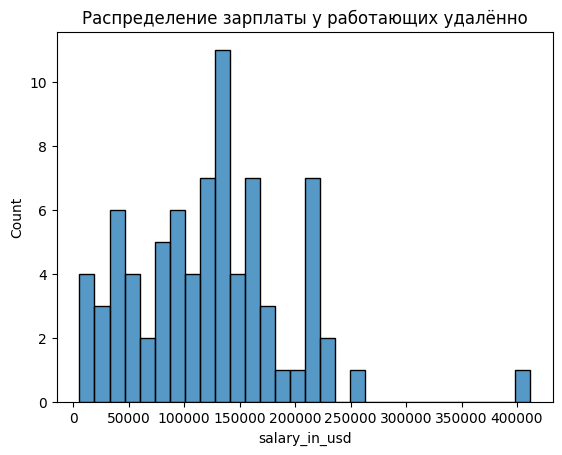

In [34]:
# Строим диаграмму распределения признака 'salary_in_usd' для датафрейма df_full_remote 
ax = sns.histplot(df_full_remote['salary_in_usd'], bins=30)
# Добавляем заголовок
ax.set_title('Распределение зарплаты у работающих удалённо')

Text(0.5, 1.0, 'Распределение зарплаты у работающих очно')

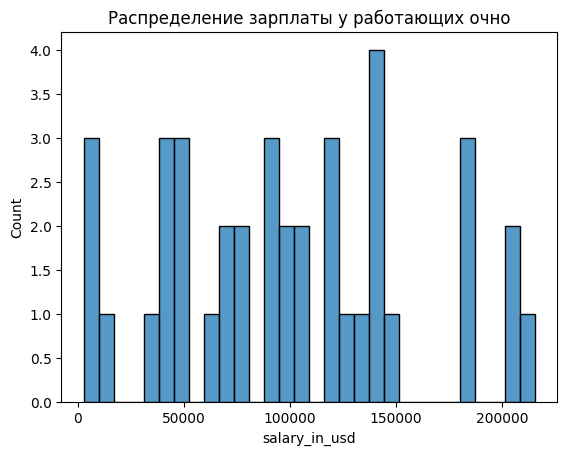

In [35]:
# Строим диаграмму распределения признака 'salary_in_usd' для датафрейма df_full_remote 
ax = sns.histplot(df_no_remote['salary_in_usd'], bins=30)
# Добавляем заголовок
ax.set_title('Распределение зарплаты у работающих очно')

Из графиков выше следует, что исследуемый признак распределён ненормально, а значит используем непараметрический тест.

Будем сравнивать группы попарно. Все признаки - независимые и количественные. Используем U-критерий Манна-Уитни.

---

*Нулевая гипотеза* ($H_0$): средняя зарплата Data Scientist, работающего удалённо, ($μ_1$) статистически меньше либо равна размеру заработной платы Data Scientist, работающего очно ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): средняя зарплата Data Scientist, работающего удалённо, ($μ_1$) статистически больше размера заработной платы Data Scientist, работающего очно ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [36]:
# Используем функцию mannwhitneyu библиотеки scipy
_, p = stats.mannwhitneyu(df_full_remote['salary_in_usd'], df_no_remote['salary_in_usd'], alternative='greater')
# Подбираем верную гипотезу
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Таким образом, Data Scientist, работающий удалённо, получает больше, чем тот, кто работает очно.

---

*Нулевая гипотеза* ($H_0$): средняя зарплата Data Scientist, работающего только удалённо, ($μ_1$) статистически меньше либо равна размеру заработной платы Data Scientist, работающего частично очно, частично удалённо ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): средняя зарплата Data Scientist, работающего только удалённо, ($μ_1$) статистически больше размера заработной платы Data Scientist, работающего частично очно, частично удалённо ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [37]:
# Используем функцию mannwhitneyu библиотеки scipy
_, p = stats.mannwhitneyu(df_full_remote['salary_in_usd'], df_partly_remote['salary_in_usd'], alternative='greater')
# Подбираем верную гипотезу
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Таким образом, Data Scientist, работающий удалённо, получает больше, чем тот, кто работает и очно, и удалённо.

---

*Нулевая гипотеза* ($H_0$): средняя зарплата Data Scientist, работающего очно, ($μ_1$) статистически меньше либо равна размеру заработной платы Data Scientist, работающего частично очно, частично удалённо ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): средняя зарплата Data Scientist, работающего очно, ($μ_1$) статистически больше размера заработной платы Data Scientist, работающего частично очно, частично удалённо ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [38]:
# Используем функцию mannwhitneyu библиотеки scipy
_, p = stats.mannwhitneyu(df_no_remote['salary_in_usd'], df_partly_remote['salary_in_usd'], alternative='greater')
# Подбираем верную гипотезу
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Таким образом, Data Scientist, работающий очно, получает больше, чем тот, кто работает по смешанному графику.

---

<span style="font-size:24px;">**Вывод:**</span> $~$ <span style="font-size:20px;">исходя из статистического теста Манна-Уитни, ЗП Data Scientist зависит от типа работы: удалённая работа > смешанная работа > очная работа.</span>

---

<i>

---

По данным Ai-jobs.net в 2022 году медианная зарплата для full-time Data Scientist составляет 150 тыс $. Проверим это суждение на основе наших данных.

Источник: https://ai-jobs.net/salaries/data-scientist-salary-in-united-states-during-2022/

In [39]:
# Фильтруем признак в соответствии с заданными условиями
mask = (data['job_title'] == 'Data Scientist') & (data['work_year'] == 2022) \
    & (data['employment_type'] == 'FT') & (data['company_location'] == 'US')
df = data[mask]
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
292,2022,MI,FT,Data Scientist,130000,0,US,M
293,2022,MI,FT,Data Scientist,90000,0,US,M
298,2022,SE,FT,Data Scientist,136620,100,US,M
299,2022,SE,FT,Data Scientist,99360,100,US,M
302,2022,SE,FT,Data Scientist,146000,100,US,M


In [40]:
# Используем тест Шапиро-Уилка для определения нормальности распределения признака salary_in_usd
_, p = stats.shapiro(df['salary_in_usd'])
if p >= alpha:
    print('Нулевая гипотеза верна - данные распределены нормально')
else:
    print('Альтернативная гипотеза верна - данные не распределены нормально')

Нулевая гипотеза верна - данные распределены нормально


Text(0.5, 1.0, 'Распределение зарплаты у работающих удалённо')

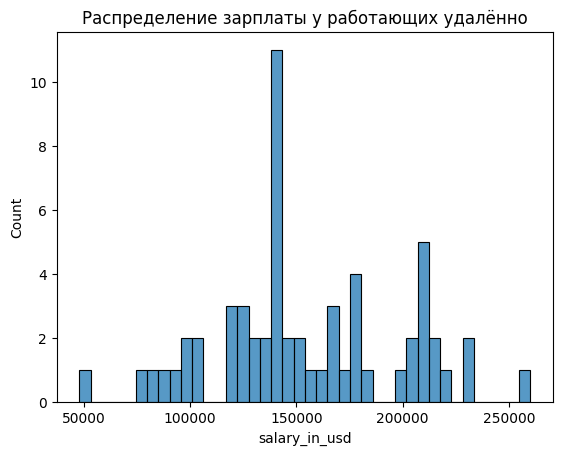

In [41]:
# Строим диаграмму распределения признака 'salary_in_usd' для датафрейма df_full_remote 
ax = sns.histplot(df['salary_in_usd'], bins=40)
# Добавляем заголовок
ax.set_title('Распределение зарплаты у работающих удалённо')

Итак, мы рассматриваем одну группу, данные распределены нормально и сам признак - количественный. Следовательно, нужно использовать одновыборочный t-критерий.

*Нулевая гипотеза* ($H_0$): средняя зарплата ($μ_1$) Data Scientist в 2022 году, работающего full-time на американскую компанию, равна 150,000 $.

$$ H_0 : μ_1 = 150,000 $$

*Альтернативная гипотеза* ($H_1$): средняя зарплата ($μ_1$) Data Scientist в 2022 году, работающего full-time на американскую компанию, не равна 150,000 $.

$$ H_1 : μ_1 ≠ 150,000 $$

In [42]:
# Используем функцию ttest_1samp() из библиотеки scipy
_, p = stats.ttest_1samp(df['salary_in_usd'], 150000, alternative='two-sided')
# Подбираем верную гипотезу
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Таким образом, у нас нет оснований полагать, что средняя ЗП Data Scientist, работающего full-time в США в 2022 году, не равна 150 тысячам, как указано в источнике. 

<span style="font-size:24px;">**Вывод:**</span> $~$ <span style="font-size:20px;">благодаря одновыборочному t-критерию удалось подтвердить среднюю зарплату Data Scientist в США за 2022 год - 150,000 $.</span>

---

<i>

---

Незамеченным остался последний признак - опыт работы ('experience_level'). Проверим, зависит ли зарплата Data Scientist от опыта работы специалиста.

In [43]:
data['experience_level'].value_counts()

experience_level
SE    280
MI    213
EN     88
EX     26
Name: count, dtype: int64

In [44]:
# Фильтруем признак так, чтобы в датафрейме осталась информация только о Data Scientist
df = data[data['job_title'] == 'Data Scientist']
# Для каждого уровня специалиста сохраним датафрейм в отедльную переменную
df_se = df[df['experience_level'] == 'SE']
df_mi = df[df['experience_level'] == 'MI']
df_en = df[df['experience_level'] == 'EN']
df_ex = df[df['experience_level'] == 'EX']

In [45]:
df_ex

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size


Как видим, в нашим данных нет специалиста по Data Science в должности Director.

*Нулевая гипотеза* ($H_0$): зарплата Data Scientist не зависит опыта работы.

*Альтернативная гипотеза* ($H_1$): зарплата Data Scientist зависит опыта работы.

Т.к. в данных упоминается 3 разных уровня специалиста, группы независимы и распределение зарплат - ненормальное, используем критерий Краскела-Уоллиса.

In [46]:
# Воспользуемся функцией kruskal() из библиотеки scipy
_, p = stats.kruskal(df_se['salary_in_usd'], df_mi['salary_in_usd'], df_en['salary_in_usd'])
# Подбираем верную гипотезу
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Как и ожидалось, ЗП Data Scientist зависит от опыта работы.<span style="font-size:24px;">**Вывод:**</span> $~$ <span style="font-size:20px;">с помощью критерия Краскела-Уоллиса выяснили, что опыт работы влияет на заработок Data Scientist.</span>

# Общий вывод

Был проведён тщательный анализ данных, в ходе которых благодаря статистическим тестам и графикам были получены следующие результаты:
* ЗП Data Scientist зависит от: размера компании, типа работы (удалённо/очно) и опыта работы специалиста.
* Средний размер ЗП Data Scientist в 2022 в США - 150,000 $.
* Рост зарплат Data Scientist был только в 2022 году, по нашим данным нельзя утверждать, что есть тренд постоянно роста зарплаты.
* Data Scientist получает больше, чем Data Engineer (по данным 2022 года).
* Существует связь между размером компании и предлагаемой в ней должностью (в крупных и маленьких компаниях чаще предлагают должность Data Scientist, в то время как в средних - Data Engineer).